In [2]:
import os
import wandb
import itertools
import pandas as pd 
os.environ["HTTPS_PROXY"] = "http://10.21.0.15:7890"    
api = wandb.Api()

In [3]:
def get_single_method(method,dataset,hypers):
    algs = method if isinstance(method,list) else [method]
    datasets = dataset if isinstance(dataset,list) else [dataset]
    runs = api.runs("henrytujia/FedTH")
    res = pd.DataFrame()

    for alg,dataset in itertools.product(algs,datasets):
        hypers.update({"method":alg,"dataset":dataset})
        for run in runs:
            # if run.id == "1qomda2w":
            #     print("ok")
            if not(run.state == 'finished'):
                continue
            state_list = [key in run.config.keys() and hypers[key] == run.config[key] for key in hypers.keys()]
            if not all(state_list):
                continue
            history = run.history()
            temp_df = pd.DataFrame({**run.config,"id":run.id,'global_test_acc':history['global_test_acc'],"epochs":[x for x in range(hypers["comm_round"])]})
            res = pd.concat([res,temp_df])
            # res.update({**run.config,"id":run.id,'global_test_acc':history['global_test_acc']})
            # if len(history) != hypers["comm_round"]:
            #     continue
            # try:
            #     res.update({**run.config,"id":run.id,'global_test_acc':history['global_test_acc']})
            # except:
            #     raise Exception("No global test on history",history.columns)
                
    return res


In [8]:
alg = ["fedict"]
dataset = ["cifar10","cifar100","cinic10"]
hypers = {
    "comm_round":500,
    "client_number":100,
    "partition_method":"hetero",
    "epochs":10,
    "weight_method":"logits"
}

df = get_single_method(alg,dataset,hypers)
# print()

In [77]:
print(df["id"].unique())

['37lxba08' 'wp2qcmgx' '2nhk83gn' 'fm60y3nc' '1a7p3skj' 'soxfrkdj'
 '5mtnzwid' '1jpc3jxw' '1yimtn3y' '10ez9spb' '1psn4bee' '1wvmgfas'
 '2mytcx59' '2lxhrsmp' '2w29nyc2' '1jyxkzpf' '24r4dvza' 'vukgmy5z'
 '98qrsnfg' 'plukqivg' '1qomda2w' '28fesdc2' '23xh4itb' 'grxvt3he'
 '1jsrbzr3' '2ax73mzz' '2gezklkj' '3h0uhwuc' 'sfm4jmrd' '2l3dnb9j'
 'p5voul22' 'o2xiapms' '1awr6r4f' '3gtj2djy' 'd6z3qkpn' '26io0b95'
 '24il6xot' '28tac45u' '1qplbzxe' '2slelp2c' 'hg0qajec' 'xmm4fjq4'
 '13m834kf' '2itg2xiv' '1oaa3jf2' '1scvsjgz' '1pd3ojku' '1qeyb38c'
 '1ayqypul' '1gcdq2fq' '1pn1jozc' 'i67zyl05' 'p5hgklss']


In [9]:
for  item in itertools.product(alg,dataset,[0.5,0.3,0.1]):
    m,d,a = item
    temp_df = df[(df["method"]==m)&(df["dataset"]==d)&(df["partition_alpha"]==a)]
    # print(temp_df["global_test_acc"])
    mean_accs = temp_df.groupby("epochs").mean()["global_test_acc"]
    print(m,d,a,mean_accs.tail(30).mean(),mean_accs.tail(30).std())
    # break



fedict cifar10 0.5 77.57244925213676 0.6433209183866295
fedict cifar10 0.3 76.01161858974359 0.5114433489269291
fedict cifar10 0.1 67.7240251068376 1.1191449063363648
fedict cifar100 0.5 55.40932158119657 0.3163185084587472
fedict cifar100 0.3 54.40137553418804 0.3118440116070171
fedict cifar100 0.1 50.84301549145299 0.4060961517910973
fedict cinic10 0.5 56.82822145061728 0.686960528000864
fedict cinic10 0.3 53.26118085232668 0.9043982782676703
fedict cinic10 0.1 43.39951329534664 1.9837480443486633


#### loss

fedict cifar10 0.5 77.95305822649571 0.6013533213365148
fedict cifar10 0.3 75.48344017094017 0.6996050865684369
fedict cifar10 0.1 67.67094017094017 0.8924363672573657
fedict cifar100 0.5 55.887419871794876 0.3177530074942643
fedict cifar100 0.3 nan nan
fedict cifar100 0.1 50.56390224358974 0.32767657226713587
fedict cinic10 0.5 57.33447590218423 0.7506156129806099
fedict cinic10 0.3 53.01404469373219 0.9471833577220373
fedict cinic10 0.1 42.87842028727446 2.1041818560622367

#### probs

fedict cifar10 0.5 76.93175747863249 1.0569725643418644
fedict cifar10 0.3 75.07244925213675 0.9149932701677147
fedict cifar10 0.1 61.886351495726494 1.8789464157524083
fedict cifar100 0.5 57.07365117521367 0.2481271588350607
fedict cifar100 0.3 56.470686431623925 0.3494735660751884
fedict cifar100 0.1 50.51749465811966 0.3335795803727152
fedict cinic10 0.5 56.9280107431149 1.3936003765791838
fedict cinic10 0.3 51.856266322412154 1.4134459471048346
fedict cinic10 0.1 38.37881350902184 1.9733524222861305
 
### logits
fedict cifar10 0.5 77.57244925213676 0.6433209183866295
fedict cifar10 0.3 76.01161858974359 0.5114433489269291
fedict cifar10 0.1 67.7240251068376 1.1191449063363648
fedict cifar100 0.5 55.40932158119657 0.3163185084587472
fedict cifar100 0.3 54.40137553418804 0.3118440116070171
fedict cifar100 0.1 50.84301549145299 0.4060961517910973
fedict cinic10 0.5 56.82822145061728 0.686960528000864
fedict cinic10 0.3 53.26118085232668 0.9043982782676703
fedict cinic10 0.1 43.39951329534664 1.9837480443486633

In [ ]:
for run in runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    # summary_list.append(run.summary._json_dict) 
    
    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}

    if not all(x in config.keys() for x in ['method','dataset']) or run.state != 'finished':
        continue

    temp_query = (config['method'],config['dataset'])

    if temp_query in polt_indexs:
        history = run.history()
        history_list.append(pd.Series(history['global_test_acc']).to_frame(config['method']))


    # config_list.append(config) 

    # run.name is the name of the run.
    # name_list.append(run.name)       
data_df = pd.concat(history_list,axis=1)

# summary_df = pd.DataFrame.from_records(summary_list) 
# config_df = pd.DataFrame.from_records(config_list) 
# name_df = pd.DataFrame({'name': name_list}) 
# all_df = pd.concat([name_df, config_df,summary_df], axis=1)

data_df.to_csv(os.path.join(*[dataset[0]]).replace("/","_")+".csv")

In [ ]:
import os
import wandb
import itertools
import pandas as pd 

os.environ["HTTPS_PROXY"] = "http://10.21.0.15:7890"    
api = wandb.Api()

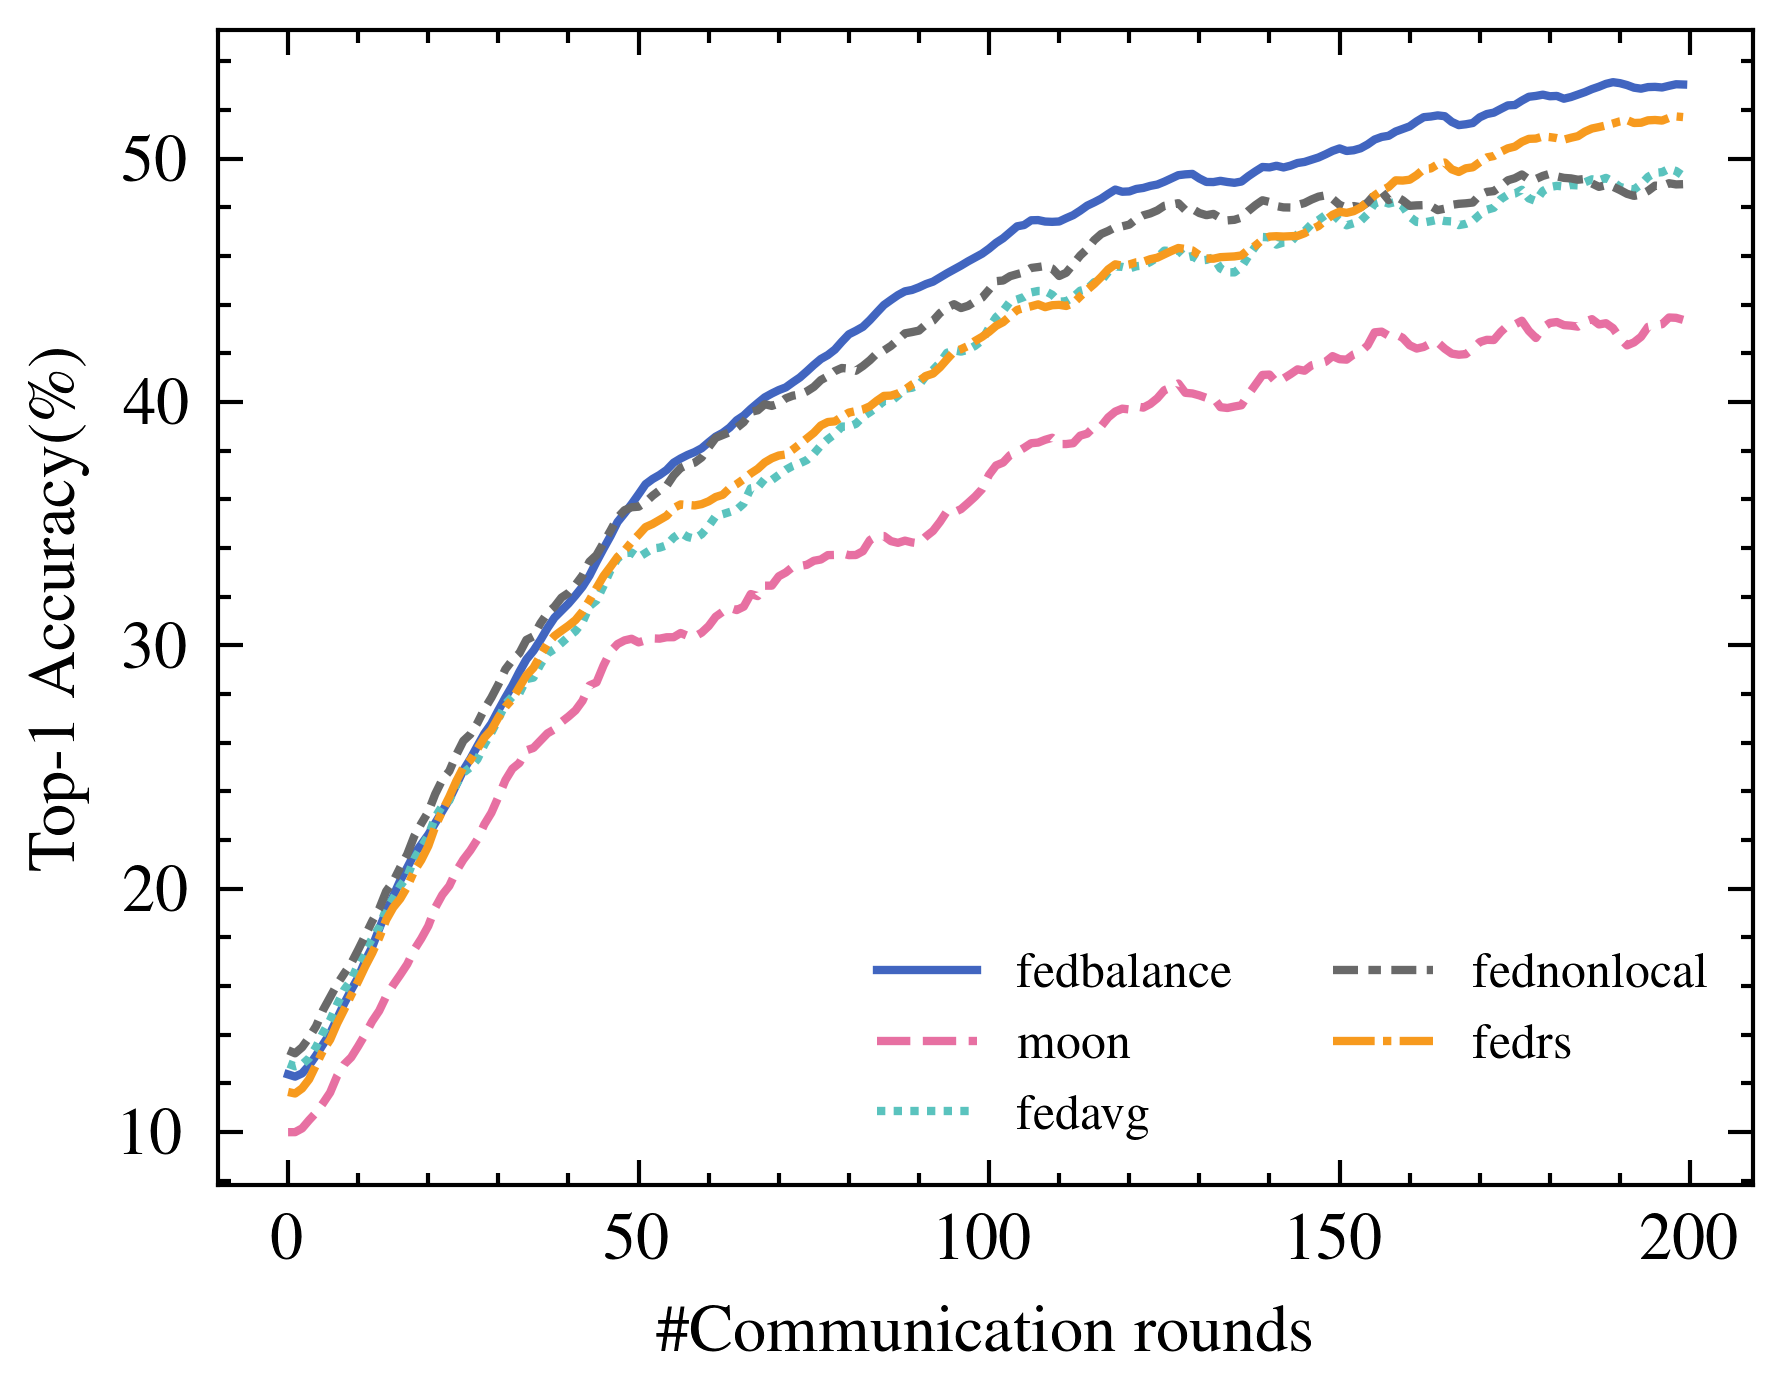

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])
df_plot = pd.DataFrame()
for index, row in data_df.iteritems():
    df_plot[index] = row.ewm(com=25,adjust=False).mean()
fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.lineplot(data = df_plot)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

In [6]:
print(data_df.tail(50).mean())
print("\n")
print(data_df.max())

fedbalance     57.700521
fedbalance     57.100962
moon           43.473357
fedavg         49.127204
fednonlocal    48.937099
fedrs          52.219952
fedbalance     53.405248
dtype: float64


fedbalance     61.969151
fedbalance     61.568510
moon           56.260016
fedavg         59.194712
fednonlocal    56.680689
fedrs          55.879407
fedbalance     57.572115
dtype: float64
